In [1]:
import sys
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import copy
sys.path.append('p3')
import gridworld as gw

In [2]:
env = gym.make('Pendulum-v0')

[2017-07-21 15:51:55,559] Making new env: Pendulum-v0


In [10]:
"""Engineered solution - no RL
Using PID controllers to keep pendulum inverted.
The CleverController is essentially an FSM with 3 states: 
    (1) zero pendulum (to stable equilibrium using PID on velocity), 
    (2) invert pendulum to unstable equilibrium using predefined procedure, 
    (3) keep pendulum inverted with a PID contoller
The inversion procedure executed as part of state (2) has three steps.
The entire controller has about 11 adjustable parameters, including 3 for theta PID coefficients, 3 for velocity PID coefficients, 3 for transitioning from state to state in controller, 2 for transitioning between states in inversion procedure.
I fiddled with the parameters for a while manually, and it almost works, the only problem is that the inversion procedure inverts too quickly so the controller isn't able to keep the pendulum inverted.
[All of this can essentially be ignored, its just fun to play with]
"""
def getAngle(y, x, v): # north is theta = 0
    theta = np.arccos(y)
    if x > 0:
        theta = -theta
    return theta

class PID_Control:
    def __init__(self, Kp=1., Ki=1., Kd=1., maxI=None):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.maxI = maxI if maxI else Ki * np.pi
        self.I = 0
        self.D = 0

    def getSol(self, theta):
        # P
        sol = self.Kp * theta

        # D
        sol += self.Kd * (theta - self.D)
        D = theta

        # I
        self.I += theta
        if self.I > self.maxI:
            self.I = self.maxI
        if self.I < -self.maxI:
            self.I = -self.maxI
        sol += self.I

        return -sol
    
    def reset(self):
        self.I = 0
        self.D = 0

# 3 states of controller
S_ZERO = 1
S_INV = 2
S_BAL = 3

# 3 states of inversion procedure
I_PUSH = 1
#I_WAIT = 2
I_REV = 2
I_SLO = 3

class CleverControl:
    def __init__(self, w_cutoff=1e-3, theta_cutoff=5 * np.pi / 10):
        self.theta_pid = PID_Control(0.1, 1, 1) # for balancing
        self.vel_pid = PID_Control(10, 1, 1) # for zeroing velocity
        self.state = S_ZERO # control state
        self.i_state = I_PUSH # inversion state - just for inversion procedure
        self.w_cutoff = w_cutoff
        self.theta_cutoff = theta_cutoff
    
    def getSol(self, theta, w):
        if self.state == S_ZERO:
            if np.abs(w) < self.w_cutoff:
                self.vel_pid.reset()
                self.i_state = I_PUSH
                self.state = S_INV # perform inversion
            return self.vel_pid.getSol(w)
        if self.state == S_INV:
            if np.abs(theta) < 5 * np.pi / 10:
                self.vel_pid.reset()
                self.state = S_BAL # start balancing
            return self.complete_inversion(theta, w)
        # continue balancing
        if np.abs(theta) > (np.pi + self.theta_cutoff)/2 :
            self.theta_pid.reset()
            self.state = S_ZERO # dropped pendulum, reset
        return self.theta_pid.getSol(theta)
    
    def complete_inversion(self, theta, w): # move from stable equilibrium to unstable equilibrium
        adj_theta = theta if theta > 0 else theta + 2 * np.pi
        if self.i_state == I_PUSH: # initial push
            if adj_theta > 6 * np.pi / 5:
                self.i_state = I_REV
            return -2
        #if self.i_state == I_WAIT: # reverse
        #    if w < self.w_cutoff:
        #        self.i_state = I_REV
        #    return -2
        if self.i_state == I_REV:
            if adj_theta < 95 * np.pi / 100: # over halfway point
                self.i_state = I_SLO
            return 2
        # I_SLO
        return -2

In [3]:
"""Running the engineered solutions - no RL"""
env = gym.make('Pendulum-v0')
env.reset()
obs = []
rewards = []
calcs = []
pid = PID_Control(10, 1, 1)
clever = CleverControl()
sol = 0
for _ in range(1000):
    #env.render()
    observation, reward, done, info = env.step(np.array([sol])) # take a random action
    obs.append(observation) # [ypos, xpos, ang-speed] - r=1
    rewards.append(reward)
    theta = getAngle(*observation)
    #sol = pid.getSol(theta)
    #sol = pid.getSol(observation[2])
    sol = clever.getSol(theta, observation[2])
    calcs.append([theta/np.pi, sol, reward, clever.state+2, clever.i_state+2, (theta if theta > 0 else theta + 2 * np.pi)/np.pi])

obs = np.hstack([np.vstack(obs),np.array(calcs)])
print sum(rewards)

[2017-07-21 15:51:55,690] Making new env: Pendulum-v0


NameError: name 'PID_Control' is not defined

In [3]:
"""Plot results from episode"""
print obs[0], obs.shape
fig, ax = plt.subplots(1,1)
labels = ['y','x','v','theta','sol','R', 'state', 'i_state', 'adj_theta']
for i in range(obs.shape[1]):
    ax.plot(obs[:,i], label=labels[i])
ax.legend()
plt.show()

NameError: name 'obs' is not defined

In [4]:
"""Print critical portion of results"""
print labels[2:]
for i in range(80, 110):
    print i, obs[i,2:]

NameError: name 'labels' is not defined

In [4]:
"""Discretize states and actions"""
def getDiscreteRange(low, high, graining):
    inc = (high-low)/(graining-1.)
    return np.arange(low,high+inc/2,inc)

graining = 19
possible_state_values = getDiscreteRange(-1., 1., graining)
possible_action_values = getDiscreteRange(-2, 2, graining)

def state_maker(observation):
    return tuple([possible_state_values[possible_state_values>=o][0] for o in observation[:-1]] + [int(observation[2]*graining)])
def action_maker():
    return possible_action_values

In [11]:
"""Useful Dictionary variants for table lookup algorithms, and RL"""
class SafeDict(dict):
    def __init__(self, default=0.):
        self.default = default 
        super(SafeDict, self).__init__()
    def __getitem__(self, idx):
        return self.setdefault(idx, self.default)

class Policy:
    def __init__(self, decision=lambda x: None, default=None): # default chooses from action space if decision returns invalid action
        self.decision = decision # lambda with state as input
        self.default = default # lambda with action_space as input
        if self.default is None:
            self.default = lambda actions: np.random.choice(actions)
    def decide(self, state, action_space): # ideally action space is a set of possible actions
        action = self.decision(state) if state is not None else None
        if action not in action_space: # invalid decision
            return self.default(action_space)
        return action
    
class Const_Policy(dict): # policy where action space is independent of state
    def __init__(self, action_space, default=None): # works if action_space is constant
        self.default = default # must be a lambda that takes no args - to randomize action each time (only when action space is independent of state)
        if self.default is None:
            self.default = lambda: np.random.choice(action_space)
        super(Policy, self).__init__()
    def __getitem__(self, idx):
        if idx not in self:
            return self.default()
        return self.__getitem__(self, idx)

In [12]:
"""Small MDP Generators with discrete state and action spaces
With either deterministic or stochastic actions"""
# stochastic generator doesn't work yet
def generate_stochastic_dynamics(num_states=5, num_terminal=1, sparsity=0.5, reward_mag=2): # returns M(s,a,s') and R(s,a) and T(s) (state is terminal)
    dynamics = np.random.rand(num_states, num_states, num_states)
    rewards = np.random.randn(num_states, num_states) * reward_mag
    remove = np.random.choice(np.arange(0,dynamics.size,1,dtype=int), size=int(sparsity*dynamics.size),replace=False)
    for cell in remove:
        dynamics[cell/num_states**2,(cell/num_states)%num_states,cell%num_states] = 0
    terminal = np.zeros(num_states, dtype=bool)
    # l1 normalization of probabilities
    for i in range(num_states):
        for j in range(num_states):
            total = np.sum(dynamics[i,j,:])
            dynamics[i,j,:] /= total if total > 0 else 1
        terminal[i] = not np.sum(dynamics[i,:,:])
    
    # rewards
    rewards = np.random.rand()
    
    return dynamics

def generate_deterministic_dynamics(num_states=5, num_terminal=1, sparsity=0.5, reward_mag=2): # returns M(s,a)=s' and R(s,a) and list of terminal states
    dynamics = np.random.randint(num_states, size=(num_states, num_states))
    rewards = np.random.randn(num_states, num_states) * reward_mag
    remove = np.random.choice(np.arange(0,dynamics.size,dtype=int), size=int(sparsity*dynamics.size),replace=False)
    for cell in remove:
        dynamics[cell/num_states,cell%num_states] = -1 # means this transition is impossible
        rewards[cell/num_states,cell%num_states] = 0
    terminal = []
    # l1 normalization of probabilities
    for i in range(num_states):
        if np.sum(dynamics[i,:]) == -num_states: # terminal state
            terminal.append(i)
    if num_terminal is None:
        return dynamics, rewards, terminal # don't worry about number of terminal states
    # fixing the number of terminal states could change the density of transitions
    while len(terminal) > num_terminal: # too many terminal states
        s = terminal.pop()
        a = np.random.randint(num_states)
        dynamics[s,] = np.random.randint(num_states)
        rewards[s,cell%num_states] = 0
    while len(terminal) < num_terminal:
        s = np.random.randint(num_states)
        dynamics[s,:] = -np.ones(num_states)
        rewards[s,:] = np.zeros(num_states)
        terminal.append(s)
    return dynamics, rewards, terminal

class MDP_det:
    def __init__(self, num_states=5, num_terminal=1, sparsity=0.5):
        self.dynamics, self.rewards, self.terminal = generate_deterministic_dynamics(num_states, num_terminal, sparsity)
        self.num_states = num_states
        self.deterministic = True
        
    def reset(self):
        self.state = np.random.randint(self.num_states)
    
    def action_space(self, state=None):
        if state is None:
            state = self.state
        return np.arange(self.num_states)[self.dynamics[state,:]>=0]
    
    def step(self, action):
        reward = self.rewards[self.state, action]
        self.state = self.dynamics[self.state, action]
        if self.state == -1:
            raise Exception('Invalid state')
        return self.state, reward, self.state in self.terminal
    
    def state_space(self):
        return np.arange(self.num_states)
    
    def getReward(self, action, newstate=None, state=None):
        if state is None:
            state = self.state
        return self.rewards[state, action]
    
    def getTransitions(self, action, state=None):
        if state is None:
            state = self.state
        return [(self.dynamics[state, action], 1.0)] # in a det MDP there is only 1 possible next state
    

In [13]:
"""Wrapper for Gridworld MDPs"""
gridWorlds = {'cliff':gw.getCliffGrid, 'cliff2':gw.getCliffGrid2, 'discount':gw.getDiscountGrid, 'bridge':gw.getBridgeGrid, 'book':gw.getBookGrid, 'maze':gw.getMazeGrid}
class GridMDP:
    def __init__(self, gridName=None, noise=0.2):
        if gridName is None:
            gridName = np.random.choice(gridWorlds.keys())
        self.gridName = gridName
        self.gridworld = gridWorlds[gridName]()
        self.gridworld.setNoise(noise)
        self.reset()
    
    def reset(self):
        self.state = self.gridworld.getStartState()
    
    def action_space(self, state=None):
        if state is None:
            state = self.state
        #print 's', state, self.gridworld.getPossibleActions(state)
        return self.gridworld.getPossibleActions(state)
    
    def sample_probs(self, probs): # returns next state
        sample = np.random.random()
        state, cumulative = probs[0]
        i = 0
        while sample > cumulative:
            i += 1
            cumulative += probs[i][1]
            state = probs[i][0]
        return state
    
    def step(self, action):
        newstate = sample_probs(self.gridworld.getTransitionStatesAndProbs(self.state, action))
        reward = self.gridworld.getReward(self.state, action, newstate)
        self.state = newstate
        return self.state, reward, self.gridworld.isTerminal(self.state)
    
    def state_space(self):
        return self.gridworld.getStates()
    
    def getReward(self, action, newstate, state=None):
        if state is None:
            state = self.state
        return self.gridworld.getReward(state, action, newstate)
    
    def getTransitions(self, action, state=None):
        if state is None:
            state = self.state
        #print 't', state, action, '{', self.action_space(state) ,'}',
        trans = self.gridworld.getTransitionStatesAndProbs(state, action)
        #print 'leads to', trans
        return trans
    

In [14]:
"""Prediction Algorithms - using dynamics model
LA and DP algorithms for solving small MDPs directly or iteratively
from generated MDPs - to get the true value function and compare it to the sampling methods below
"""
class LASolver: # solve using linear algebra v = (1 - discount*dynamics)^-1*rewards
    def __init__(self, mdp, policy=None):
        self.mdp = mdp
        self.policy = policy # if None, then this is find the optimal policy
        if self.mdp.deterministic:
            self.det_solve()
        else:
            self.sto_solve()

class ValueIterationSolver:
    def __init__(self, mdp, policy=None, discount=0.9, threshold=1e-3):
        self.mdp = mdp
        self.policy = policy
        self.givenPolicy = policy is not None
        self.discount = discount
        self.values = SafeDict()
        self.threshold = threshold # threshold for convergence
        self.solved = False
        self.iterations = 0 # iterations completed
    
    def _improveValues(self): # internal function
        self.iterations += 1
        newValues = SafeDict()
        max_delta = 0
        for s in self.mdp.state_space():
            if self.givenPolicy:
                newValues[s] = self.computeQValueFromValues(s, self.policy.decide(s, self.mdp.action_space(s)))
            else:
                options = [ self.computeQValueFromValues(s, a) for a in self.mdp.action_space(s)]
                if len(options): # not terminal state
                    newValues[s] = max(options)
            error = np.abs(self.values[s] - newValues[s])
            if error > max_delta:
                max_delta = error
        self.values = newValues
        return max_delta
    
    def computeQValueFromValues(self, state, action):
        return sum([ prob * (self.mdp.getReward(state=state, action=action, newstate=sp) + (self.discount * self.values[sp])) 
                for sp, prob in self.mdp.getTransitions(state=state, action=action)])
    
    def slowCompute(self, state, action):
        parts = [ prob * (self.mdp.getReward(state=state, action=action, newstate=sp) + (self.discount * self.values[sp])) 
                for sp, prob in self.mdp.getTransitions(action=action,state=state)]
        #print '--res s:', state, 'a:', action, 'calc:', parts
        return sum(parts)
    
    def iterate(self, iterations=10): # iterates regardless of whether mdp is already solved
        delta = 0
        for _ in range(iterations):
            delta = self._improveValues()
        if delta < self.threshold: self.solved = True
        return delta # from last iteration
    
    def solve(self, threshold=None): # only solves in passed in threshold is smaller than solved threshold
        if self.solved and threshold is not None and threshold >= self.threshold:
            return -1 # mdp is already solved
        if threshold is not None:
            self.threshold = threshold
            self.solved = False
        converged = False
        delta = 0
        while not converged:
            delta = self._improveValues()
            converged = delta < self.threshold
        self.solved = True
        return self.iterations # total number of iterations completed
            
    def getValue(self, state):
        return self.values[state]
    
    def getPolicy(self):
        if not self.givenPolicy:
            if not self.solved: self.solve()
            self.policy = Policy(decision=self.computeActionFromValues)
        return self.policy
    
    def computeActionFromValues(self, state):
        actions = self.mdp.getPossibleActions(state)
        if not len(actions):
            return None
        values = [self.computeQValueFromValues(state, a) for a in actions]
        return max(zip(actions,values),key=lambda x: x[1])[0]
        

In [9]:
"""Run Value Iteration on Gridworld MDPs"""
for name in gridWorlds.keys():
    print name, ValueIterationSolver(GridMDP(name)).solve() # prints number of iterations until convergence

bridge 5
discount 30
book 16
maze 23
cliff2 17
cliff 21


In [10]:
"""Model Free Prediction Algorithms - for policy evaluation
Standard Monte Carlo - only adjusts value function at the end of the episode
TD(0) - bootstraps each step to incrementally improve value function
TD(lambda) - bootstraps with eligibility function, to change between MC and TD
"""
class MC:
    def __init__(self, policy=Policy(), alpha=0.1, discount=0.9):
        self.alpha = alpha
        self.discount = discount
        self.values = SafeDict()
        self.policy = policy
        self.episode = [] # keeps track of visited states in this episode
        self.gain = 0
        self.state = None
        
    def take_action(self, actions):
        return self.policy.decide(self.state, actions)
    
    def eval_action(self, newstate, reward):
        self.episode.append(newstate)
        self.state = newstate
        self.gain += reward
        return self.gain
    
    def reset(self): # for MC this is where value function is improved
        total_discount = 1
        while len(self.episode):
            s = self.episode.pop()
            self.values[s] += self.alpha * (total_discount * self.gain - self.values[s])
            total_discount *= self.discount
        self.episode = []
        self.gain = 0
        self.state = None

class TD:
    def __init__(self, policy=Policy(), alpha=0.1, discount=0.9):
        self.alpha = alpha
        self.discount = discount
        self.values = SafeDict() # value function
        self.state = None
        self.policy = policy
    
    def take_action(self, actions): # reward is from previous action
        return self.policy.decide(self.state, actions)
    
    def eval_action(self, newstate, reward):
        if self.state is not None:
            self.values[self.state] += self.alpha * (reward + self.discount * self.values[newstate] - self.values[self.state])
            exp_reward = self.values[self.state]
        self.state = newstate
        return self.values[self.state] # return metric (eg. expected reward, loss, etc.)
    
    def reset(self):
        self.state = None

class TD_lambda:
    def __init__(self, policy=Policy(), alpha=0.1, discount=0.9, lmbda=0.9, threshold=1e-6):
        self.alpha = alpha
        self.discount = discount
        self.lmbda = lmbda
        self.threshold = threshold # remove insignificantly small elig. states to improve performance
        self.values = SafeDict() # value function
        self.policy = policy
        self.eligibility = SafeDict()
        self.state = None
    
    def take_action(self, actions): # reward is from previous action
        return self.policy.decide(self.state, actions)
    
    def eval_action(self, newstate, reward):
        if self.state is not None:
            for s in self.eligibility.keys():
                self.eligibility[s] *= self.discount * self.lmbda
                if self.eligibility[s] < self.threshold: del self.eligibility[s] # remove insignificant states
            self.eligibility[self.state] += 1
            for s in self.eligibility.keys():
                self.values[s] += self.alpha * self.eligibility[s] * (reward + self.discount * self.values[newstate] - self.values[self.state])
        self.state = newstate
        return self.values[self.state]
    
    def reset(self): # reset at the end of an episode
        self.eligibility = SafeDict()
        self.state = None
    

In [27]:
""" Run policy evaluation (prediction) """
learner = TD_lambda() # random policy
watcher = MC()
found_states = []
episodes = 10
printstep = episodes / 100 if episodes > 100 else 1
steps = 20
for i in range(1,episodes+1): # number of episodes
    episode_len = 0
    mdp.reset()
    learner.reset()
    watcher.reset()
    if i % printstep == 0: print '\nEpsiode', i, '\n   ',
    state = None
    reward = None
    done = len(mdp.action_space()) == 0
    for _ in range(steps): # steps per episode
        print mdp.state,
        if done: break
        state, reward, done = mdp.step(learner.take_action(mdp.action_space()))
        learner.eval_action(state, reward)
        watcher.eval_action(state, reward)
        #state = state_maker(observation) # only neede if ai gym env is used
        episode_len += 1
    if i % printstep == 0: print '\n--- len:', episode_len
    found_states.append(len(learner.values))

#plt.plot(found_states) # shouldn't really decrease, since policy doesn't change
#plt.set_title('Number of States in Value Function')
#plt.show()


Epsiode 1 
    3 5 3 1 0 1 7 7 2 6 6 4 5 0 1 5 3 1 4 4 
--- len: 20

Epsiode 2 
    5 6 6 7 2 6 9 5 0 1 4 9 7 7 7 3 5 4 1 7 
--- len: 20

Epsiode 3 
    1 4 1 0 1 5 4 1 4 5 5 3 5 2 6 4 4 1 8 3 
--- len: 20

Epsiode 4 
    6 6 4 4 1 7 2 3 7 2 2 2 3 5 6 7 2 2 2 6 
--- len: 20

Epsiode 5 
    0 1 0 7 7 7 3 1 4 9 7 2 6 8 3 5 0 1 0 1 
--- len: 20

Epsiode 6 
    2 6 4 1 0 1 7 3 5 2 3 3 1 5 3 3 3 7 3 5 
--- len: 20

Epsiode 7 
    6 7 7 2 6 8 3 5 4 5 2 2 2 2 2 2 3 5 6 7 
--- len: 20

Epsiode 8 
    6 9 5 6 6 7 7 2 6 7 3 1 8 1 5 6 9 7 2 6 
--- len: 20

Epsiode 9 
    4 1 4 4 1 4 9 7 7 3 7 2 6 7 2 6 6 9 5 0 
--- len: 20

Epsiode 10 
    1 8 3 7 2 6 9 5 3 7 7 3 3 1 7 2 6 9 7 7 
--- len: 20


/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:56: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [30]:
print learner.values
print watcher.values
print mdp.dynamics
print mdp.rewards

{0: 0.32746219982543262, 1: 1.3873989033421574, 2: 2.3580000650861197, 3: -0.52857320091308935, 4: 2.3788966374139067, 5: 1.239465330212578, 6: 2.5836677480701722, 7: 2.8050054952204402, 8: -0.36247067021576101, 9: 0.3457815966920964}
{0: 2.0111339650985962, 1: 2.2889372654410227, 2: 4.5682712360122979, 3: 0.21851437452260258, 4: 4.0093298685688943, 5: 2.683639996678953, 6: 5.0733909294657034, 7: 3.6098765925342056, 8: 1.5789932990070976, 9: 2.4750429573618922}
[[ 4  1 -1 -1  1 -1  1  7 -1 -1]
 [-1 -1 -1 -1  8  5 -1  0  4  7]
 [ 6  6 -1 -1  2 -1 -1 -1  3 -1]
 [ 7 -1 -1  1 -1 -1  3 -1  5  5]
 [-1 -1  1  4  9 -1  1 -1  5  4]
 [ 5  2 -1  4  3 -1  0 -1  6  0]
 [-1 -1  4  7 -1 -1  6  8  9 -1]
 [-1 -1 -1 -1  7 -1 -1 -1  3  2]
 [ 3 -1  1 -1  8  7 -1  3  9 -1]
 [-1  7  5 -1  7  5 -1 -1 -1 -1]]
[[ 0.73553855  1.33535896  0.          0.         -2.39580335  0.
  -1.41853329  2.94177738  0.          0.        ]
 [ 0.          0.          0.          0.          2.20948158 -3.9092334
   0.        

In [14]:
"""Model-Free Control
On policy: SARSA - similar to TD, but now with epsilon greedy action choices\
           SARSA(lambda) - similar to TD(lambda)
Off policy: Q-learning
"""
class SARSA: # on policy - so policy is run while improving
    def __init__(self, policy=None, alpha=0.1, discount=0.9, epsilon=0.1):
        self.alpha = alpha
        self.discount = discount
        self.explore = lambda: epsilon > np.random.rand() # epsilon-greedy - constant epsilon
        self.Q = SafeDict() # Q function
        self.E = SafeDict() # eligibility
        self.policy = policy
        if self.policy is None:
            self.policy = self.getPolicy() # epsilon greedy policy
        self.prevstate = None
        self.prevaction = None
        self.reward = 0
        self.state = None # current
    
    def take_action(self, actions): # reward is from previous action
        action = self.policy.decide(self.state, actions)
        if self.prevstate is not None: # update Q function
            self.Q[self.prevstate, self.prevaction] += self.alpha * (reward + self.discount * self.Q[self.state, action] - self.Q[self.prevstate, self.prevaction])
        self.prevaction = action
        return action
    
    def eval_action(self, newstate, reward):
        if self.state is not None:
            self.prevstate = self.state
        self.state = newstate
        self.reward = reward
        return self.Q[self.prevstate, self.prevaction]
    
    def __chooseAction(self, state): # epsilon-greedy policy
        if not self.explore(): # exploit
            options = [(a, self.Q[sa]) for sa in [key for key in self.Q.keys() if key[0]==s]]
            if len(options):
                return max(options, key=lambda x: x[1])[0] # argmax
        return None # policy will pick a random action
    
    def getPolicy(self): # updates current policy if a prior policy was given
        self.policy = Policy(decision=self.__chooseAction)
        return self.policy

class SARSA_lambda: # on policy - so policy is run while improving
    def __init__(self, policy=Policy(), alpha=0.1, discount=0.9, epsilon=0.1, lmbda=0.9, threshold=1e-6):
        self.alpha = alpha
        self.policy = policy # prior
        self.discount = discount
        self.lmbda = lmbda
        self.explore = lambda: epsilon > np.random.rand() # epsilon-greedy - constant epsilon
        self.threshold = threshold # remove insignificantly small elig. states to improve performance
        self.Q = SafeDict() # Q function
        self.E = SafeDict() # eligibility
        self.state = None
        self.action = None
    
    def take_action(self, actions): # reward is from previous action
        if not (self.prevstate and self.prevaction): # initial move
            self.prevstate = state
            action = np.random.choice(actions)
            self.prevaction = action
            return action
        if self.explore():
            action = np.random.choice(actions)
        else: # exploit
            action = max([(a, self.Q[state, a]) for a in actions], key=lambda x: x[1])[0] # argmax
        for sa in self.E.keys():
            self.E[sa] *= self.discount * self.lmbda
            if self.E[sa] < self.threshold: del self.E[sa] # remove insignificant states
        self.E[self.prevstate, self.prevaction] += 1
        for sa in self.E.keys():
            self.Q[sa] += self.alpha * self.E[sa] * (reward + self.discount * self.Q[state, action] - self.Q[self.prevstate, self.prevaction])
        self.prevstate = state
        self.prevaction = action
        return action
    
    def eval_action(self, newstate, reward):
        
    
    def reset_eligibility(self): # reset at the end of an episode
        self.E = SafeDict()
        self.prevstate = None
        self.prevaction = None
    
class Q_learning: # off policy - does not choose action, merely observes
    def __init__(self, policy=Policy(), alpha=0.1, discount=0.9):
        self.alpha = alpha
        self.policy = policy
        self.discount = discount
        self.Q = SafeDict() # Q function
        self.prevstate = None
        self.prevaction = None
    
    #def take_action(self, actions):
    #    return 
        
    #def eval_action(self, newstate, reward):
        
    def step(state, action, reward): # reward is from previous action into state
        if not (self.prevstate and self.prevaction): # initial move
            self.prevstate = state
            self.prevaction = action
        self.Q[self.prevstate, self.prevaction] += self.alpha * (reward + self.discount
                                                                 * max([self.Q[state, a] for a in actions])
                                                                 - self.Q[self.prevstate, self.preaction])
        self.prevstate = state
        self.prevaction = action
        

In [15]:
"""Reset learner and data collection"""
learner = SARSA_lambda()
gains = []

Epsiode 1 - gain: -5952.03457511
Epsiode 2 - gain: -5853.63124226
Epsiode 3 - gain: -7296.58629455
Epsiode 4 - gain: -5875.67538136
Epsiode 5 - gain: -6598.39223028
Epsiode 6 - gain: -7261.85219028
Epsiode 7 - gain: -5640.05912505
Epsiode 8 - gain: -6912.77861467
Epsiode 9 - gain: -7036.30136459
Epsiode 10 - gain: -6760.38745425
Epsiode 11 - gain: -7035.74502924
Epsiode 12 - gain: -7431.65303987
Epsiode 13 - gain: -5579.18800708
Epsiode 14 - gain: -5335.11050271
Epsiode 15 - gain: -7007.18570831
Epsiode 16 - gain: -5540.26640541
Epsiode 17 - gain: -7347.84055239
Epsiode 18 - gain: -8709.31660438
Epsiode 19 - gain: -5203.95011434
Epsiode 20 - gain: -8440.31584749
Epsiode 21 - gain: -5099.06069531
Epsiode 22 - gain: -4868.73655659
Epsiode 23 - gain: -8053.34767412
Epsiode 24 - gain: -4735.35905924
Epsiode 25 - gain: -7395.82240147
Epsiode 26 - gain: -6785.95484001
Epsiode 27 - gain: -6815.79108957
Epsiode 28 - gain: -4597.267665
Epsiode 29 - gain: -7707.99249724
Epsiode 30 - gain: -4573.

<IPython.core.display.Javascript object>


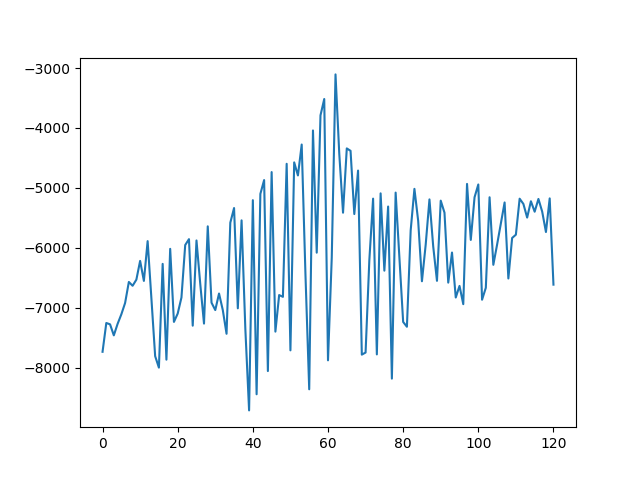

In [10]:
"""Run Model-Free Control"""
actions = action_maker()
episodes = 100
printstep = episodes / 100
steps = 1000
for i in range(episodes): # number of episodes
    env.reset()
    learner.reset_eligibility()
    if i and i % printstep == 0: print 'Epsiode', i, 
    gain = 0
    state = None
    reward = None
    for _ in range(steps): # steps per episode
        observation, reward, done, info = env.step(np.array([learner.take_action(state, reward, actions)]))
        state = state_maker(observation)
        gain += reward
    if i and i % printstep == 0: print '- gain:', gain
    gains.append(gain)

plt.plot(gains) # shouldn't really decrease, since policy doesn't change
#plt.set_title('Gain')
plt.show()

In [42]:
"""Function Approximation - based on TD but now in continuous state space using a NN to approximate Q function with discrete action space,
Action out framework - so output is expected value of each possible action"""
def net_maker(actions, activator=None):
    if activator:
        return nn.Sequential(
            nn.Linear(3, 20),
            activator(),
            nn.Linear(20, 50),
            activator(),
            nn.Linear(50, 20),
            activator(),
            nn.Linear(20, len(actions)),
            )
    return nn.Sequential(
            nn.Linear(3, 20),
            nn.Linear(20, 50),
            nn.Linear(50, 20),
            nn.Linear(20, len(actions)), # action out
            )

class TD_net:
    def __init__(self, actions, activator=None, alpha=0.001, discount=0.9, epsilon=0.1):
        self.discount = discount
        self.explore = lambda: epsilon > np.random.rand() # epsilon-greedy - constant epsilon
        self.actions = actions # total action space
        self.model = net_maker(actions, activator)
        self.optimizer = optim.SGD(self.model.parameters(), lr=alpha, momentum=0.9)
        self.criterion = nn.MSELoss()
        self.state = None
        self.iter_counter = 0
    
    def sample_actions(self, expectations, actions):
        expectations -= expectations.min() # guarantee expectations are positive, also makes it impossible to pick worst action
        expectations /= np.sum(expectations) # l1 normalization
        options = zip(actions, np.cumsum(expectations))
        sample = np.random.sample()
        try:
            action = [o[0] for o in options if sample < o[1]][-1]
        except:
            print 'expectations', np.sum(expectations), expectations, sample
            raise Exception('Sampling failed')
        return action
    
    def take_action(self, actions):
        if self.state is None: # initial move
            action = np.random.choice(actions)
            return action
        expectations = self.copy_model(self.state).data.numpy()
        if self.explore():
            action = self.sample_actions(expectations, actions)
        else: # exploit
            action = actions[expectations.argmax()] # greedy
        return action
    
    def eval_action(self, newstate, reward):
        if self.iter_counter % 200 == 0:
            self.copy_model = copy.deepcopy(self.model) # update frozen net
            print 'cloned'
        self.iter_counter += 1
        newstate = Variable(torch.Tensor(newstate))
        if self.state is None: # initial move
            self.state = newstate
            return -1
        target = Variable(reward + self.discount*self.copy_model(newstate).data) # get target from frozen net
        self.optimizer.zero_grad()
        loss = self.criterion(self.model(self.state), target)
        loss.backward()
        self.optimizer.step()
        self.state = newstate
        return loss.data[0]
    
    def reset_state(self): # reset at the end of an episode
        #self.E = SafeDict()
        self.state = None

In [77]:
"""Run Function Approximation Control
Loss seems to be blowing up - not sure why, but I'm probably using pytorch incorrectly.
"""
actions = action_maker()
learner = TD_net(actions, epsilon=1)# nn.PReLU)
gains = []
losses = []
initial_states = []
episodes = 1000
printstep = episodes / 100
steps = 50
for i in range(episodes): # number of episodes
    env.reset()
    learner.reset_state()
    if i and i % printstep == 0: print 'Epsiode', i, 
    gain, total_loss = 0, 0
    state = None
    for _ in range(steps): # steps per episode
        action = learner.take_action(actions)
        state, reward, done, info = env.step(np.array([action]))
        state = state[np.newaxis,:]
        loss = learner.eval_action(state, reward)
        if loss < 0: 
            total_loss += 1 # compensate for loss flag
            initial_states.append(state[0])
            print state, # print initial state
        print loss
        gain += reward
        total_loss += loss
        if loss > 1000:
            print '***Terminating episode, loss:', loss
            break
        if np.isnan(loss): 
            raise Exception('Loss is nan')
    avg_loss = total_loss / steps
    if i and i % printstep == 0: print '- gain:', gain, '- avg loss:', avg_loss
    gains.append(gain)
    losses.append(avg_loss)

plt.plot(gains, 'g') # shouldn't really decrease, since policy doesn't change
plt.plot(losses[::steps], 'r')
#plt.set_title('Gain')
plt.show()


cloned
[[-0.05837421  0.99829477  1.87171567]] -1
9.14186859131
16.1515979767
29.813325882
54.0486297607
93.0350646973
149.276870728
201.079483032
145.633987427
93.2929458618
49.5133476257
19.7073459625
7.2900147438
10.4125976562
19.4332084656
22.7858829498
17.6324615479
9.11035919189
2.37312602997
0.248560145497
5.38723897934
22.0656356812
40.7287826538
59.3060035706
73.8851165771
70.0759048462
9.14687633514
94.2956695557
59.6219787598
2.55029368401
3.16994833946
8.51421546936
10.1689586639
10.6526412964
12.1436080933
16.4912319183
26.7265853882
48.7213859558
71.8413696289
100.85144043
144.04548645
204.45451355
234.625259399
167.487030029
116.512413025
74.5900726318
43.9545211792
24.1094455719
12.8244552612
7.5378537178
[[-0.99319975  0.11642273 -0.51335062]] -1
78.0467300415
73.7586593628
70.8739624023
69.2610244751
68.5928878784
60.4430885315
45.5963020325
31.0697956085
18.7965965271
10.9751663208
8.71903133392
10.2687778473
11.4640035629
9.54667758942
5.49582052231
1.87930822372
0.

1.89517498016
30.2291717529
8.10415840149
14.4949035645
21.3750209808
0.0442140810192
8.61631011963
12.1093997955
6.66221189499
1.34741175175
0.052384853363
1.1881455183
2.13338756561
1.95091855526
1.0899169445
0.270260304213
0.0208190288395
0.72836714983
2.71994042397
6.1069893837
10.3120079041
13.558224678
13.1935567856
7.83084201813
1.10938298702
2.13996291161
8.98536396027
3.77898573875
0.115178219974
1.11206781864
2.07271933556
1.92438864708
1.05636632442
0.397139489651
0.269469290972
0.521948814392
0.959524929523
1.16725695133
0.75469404459
0.161159604788
0.0234397687018
4.7852268219
0.925053119659
2.34485435486
3.19709920883
[[-0.86203086 -0.5068558  -0.2272859 ]] -1
456.330596924
21.5466861725
46.6565628052
152.307983398
224.03276062
266.545288086
292.250244141
307.717803955
315.188079834
314.326782227
303.03024292
277.623138428
233.010696411
164.395309448
75.7890319824
5.08642530441
39.1857948303
145.312759399
94.7388916016
9.38760662079
5.97496175766
31.7502689362
49.84947586

Exception: Loss is nan

In [78]:
inits = np.vstack(initial_states)
losses = np.array([0] + losses)[:,np.newaxis]
print inits.shape[0], 'episodes'

(24, 3)


In [79]:
stats = np.hstack([inits, losses])
print stats

[[ -5.83742133e-02   9.98294772e-01   1.87171567e+00   0.00000000e+00]
 [ -9.93199753e-01   1.16422727e-01  -5.13350623e-01   5.45293323e+01]
 [ -9.67992201e-01   2.50980277e-01   1.21096719e+00   1.77453742e+01]
 [ -9.73128794e-01   2.30261483e-01  -5.49484875e-01   1.13094344e+01]
 [ -4.27033944e-01   9.04235595e-01  -1.27920896e-01   6.96632859e+00]
 [  1.70820671e-01   9.85302136e-01   1.27821046e+00   2.81670149e+00]
 [  5.03308648e-01   8.64106709e-01   1.61941023e+00   4.18443778e+00]
 [  7.21799148e-01   6.92102586e-01  -6.49977860e-01   3.26683156e+00]
 [  1.02560183e-01   9.94726801e-01   4.85706431e-02   4.95642258e+00]
 [ -9.25350684e-01  -3.79112268e-01  -1.46009277e+00   6.67516504e+00]
 [  4.35024833e-01  -9.00418455e-01  -6.74836405e-01   6.04275755e+00]
 [  9.67836358e-01  -2.51580571e-01  -4.00796854e-01   1.98596893e+01]
 [ -8.13413509e-01   5.81685880e-01   1.42324162e-01   3.58606127e+01]
 [ -8.62030860e-01  -5.06855795e-01  -2.27285904e-01   5.54128362e+00]
 [ -3.